# Testing FFNN on classification problems

In [2]:
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import itertools
import autograd.numpy as np
import pandas as pd
from tqdm import tqdm

from activation_functions import *
from cost_functions import *
from FFNN import *

# Setting the random seed
np.random.seed(42)


In [30]:

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
# Extract data (features) and target (labels)
X = mnist.data[:2500]
y = mnist.target[:2500]

# Scaling the mnist pixel values from 0-255 to 0-1
X = X / 255.0

print(X.shape)
print(y.shape)

(2500, 784)
(2500,)


In [31]:
# Splitting the data into testing, training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

# Testing parameter combinations with grid search

In [14]:
# Splitting the data into testing an training sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

In [ ]:
# Define parameters
layer_sizes = [25, 250, 1000]
num_hidden_layers = [0, 1, 2, 3]
etas = np.logspace(-1, -2, num=2)
activation_functions = [sigmoid, ReLU, leaky_ReLU]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [ ]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results1 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results1.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

# Evaluate results
df_results1 = pd.DataFrame(results1)

# Save results to file
df_results1.to_csv("Mnist2500_results_rough.csv", index=False)

  2%|▏         | 3/144 [00:04<03:38,  1.55s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
 33%|███▎      | 48/144 [01:14<02:28,  1.55s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  

In [ ]:
# Load the results from CSV
df_results1 = pd.read_csv("Mnist2500_results_rough.csv")

# Get top 25 configurations
top_50 = df_results1.nlargest(50, 'val_acc').copy()
top_50

,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc
72,1,250,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.920,0.910
73,1,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.996667,0.912,0.908
88,1,1000,0.01,sigmoid,100,train_network_SRMSprop,0.994000,0.906,0.914
120,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.988000,0.906,0.894
136,2,1000,0.01,sigmoid,100,train_network_SRMSprop,0.972667,0.904,0.866
121,2,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.987333,0.898,0.892
104,2,25,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.894,0.870
56,1,25,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.878,0.844
80,1,1000,0.10,sigmoid,100,train_network_SRMSprop,0.948667,0.874,0.814
89,1,1000,0.01,sigmoid,100,train_network_stocastic_ADAM,0.994667,0.874,0.896


In [20]:
print(top_50['n_hidden'].value_counts())
print(top_50['layer_size'].value_counts())
print(top_50['eta'].value_counts())
print(top_50['activation'].value_counts())
print(top_50['optimizer'].value_counts())

n_hidden
0    29
1    11
2    10
Name: count, dtype: int64
layer_size
25      22
250     16
1000    12
Name: count, dtype: int64
eta
0.01    33
0.10    17
Name: count, dtype: int64
activation
sigmoid       24
softmax       12
leaky_ReLU     7
ReLU           7
Name: count, dtype: int64
optimizer
train_network_SRMSprop          29
train_network_stocastic_ADAM    21
Name: count, dtype: int64


In [ ]:
# Define parameters
layer_sizes = [25, 100, 250, 500, 1000]
num_hidden_layers = [0, 1, 2, 3, 4]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM, train_network_stocastic_momentum, train_network_momentum]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [ ]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results2 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results2.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

# Evaluate results
df_results2 = pd.DataFrame(results2)

# Save results to file
df_results2.to_csv("Mnist2500_results_depth.csv", index=False)

100%|██████████| 32/32 [50:59<00:00, 95.60s/it] 


In [38]:
# Get top 10 configurations
top_10 = df_results2.nlargest(10, 'val_acc').copy()
top_10


,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc
14,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.996667,0.932,0.898
28,3,250,0.01,sigmoid,100,train_network_SRMSprop,0.994000,0.912,0.890
15,1,500,0.01,sigmoid,100,train_network_stocastic_ADAM,0.996000,0.908,0.898
20,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.986000,0.908,0.874
10,1,100,0.01,sigmoid,100,train_network_SRMSprop,0.998667,0.902,0.888
19,2,100,0.01,sigmoid,100,train_network_stocastic_ADAM,0.998000,0.902,0.876
21,2,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.992667,0.902,0.896
22,2,500,0.01,sigmoid,100,train_network_SRMSprop,0.984667,0.902,0.878
30,3,500,0.01,sigmoid,100,train_network_SRMSprop,0.964000,0.900,0.888
26,3,100,0.01,sigmoid,100,train_network_SRMSprop,0.996667,0.896,0.886


## Network architecture heatmap

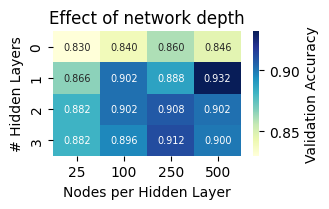

In [39]:
# Load the results from CSV
df_results = pd.read_csv("Mnist2500_results_depth.csv")

# Get unique values for the axes (switched)
num_hidden_layers = sorted(df_results['n_hidden'].unique())
layer_sizes = sorted(df_results['layer_size'].unique())

# Create 2D array for heatmap (dimensions switched)
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

# Fill the results array with validation accuracy (indices switched)
for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):
        # Filter for this specific combination
        mask = (df_results['n_hidden'] == num_layers) & (df_results['layer_size'] == layer_size)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

# Create heatmap with new formatting (labels switched)
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=layer_sizes,
            yticklabels=num_hidden_layers,
            cbar_kws={'label': 'Validation Accuracy'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Nodes per Hidden Layer')
ax.set_ylabel('# Hidden Layers')
ax.set_title('Effect of network depth', pad=6)
plt.tight_layout()
plt.show()

## Activation function test

In [ ]:
# Define parameters
layer_sizes = [25, 100, 250, 500]
num_hidden_layers = [0, 1, 2, 3]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [ ]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results3 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results2.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

# Evaluate results
df_results2 = pd.DataFrame(results3)

# Save results to file
df_results2.to_csv("Mnist2500_results_optim.csv", index=False)